In [ ]:
import re
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

In [ ]:
# read files
train = pd.read_csv("Training Data.csv")
test = pd.read_csv("Test Data.csv")

# drop columns
train.drop(['CITY', 'Id'], inplace=True, axis=1)
test.drop(['CITY', 'ID'], inplace=True, axis=1)

# find existing patterns in the dataset
pattern = {"others": 0}
for row in train['Profession']:
  arr = re.split('_', row)
  for e in arr:
    pattern[e] = 0

# do one-hot encoding
train = pd.get_dummies(train, columns=['Married/Single', 'House_Ownership', 'Car_Ownership', 'STATE'])
test = pd.get_dummies(test, columns=['Married/Single', 'House_Ownership', 'Car_Ownership', 'STATE'])

In [ ]:
# feature hashing
def FH(dataset, pattern):
  # calculate vector of all rows(train)
  occurrence = []

  for row in dataset['Profession']:
    arr = re.split('_', row)
    cur_pattern = pattern.copy()
    for e in arr:
      if e in cur_pattern:
        cur_pattern[e] = cur_pattern[e] + 1
      else:
        cur_pattern['others'] = cur_pattern['others'] + 1
    occurrence.append(cur_pattern)

  # do feature hashing
  h = FeatureHasher(len(pattern))
  return h.fit_transform(occurrence).toarray()

In [ ]:
train['Profession'] = FH(train, pattern)
test['Profession'] = FH(test, pattern)

In [ ]:
x_train = train.loc[:, train.columns != 'Risk_Flag'].to_numpy()
y_train = train['Risk_Flag'].to_numpy()
x_test = test.to_numpy()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=1234)

In [ ]:
with open('train.npy', 'rb') as f:
    X_train = np.load(f)
    Y_train = np.load(f)
with open('test.npy', 'rb') as f:
    X_test = np.load(f)
    Y_test = np.load(f)

In [ ]:
# train models
clf = RandomForestClassifier(n_estimators=3, max_depth=100)
clf.fit(X_train, Y_train)

# save model

joblib.dump(clf, 'random_forest.joblib')

['random_forest.joblib']

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.8914021164021164


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


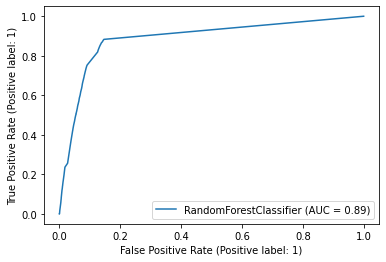

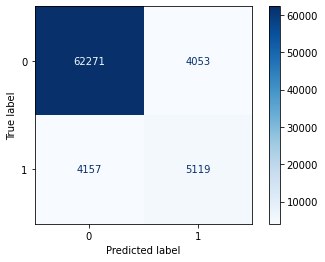

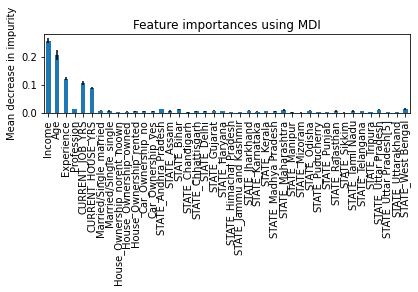

In [ ]:
plot_roc_curve(clf, X_test, Y_test)
print(clf.score(X_test, Y_test))
Y_pred = clf.predict(X_test)

# confusion matrix
cm = plot_confusion_matrix(clf, X_test, Y_test, cmap=plt.cm.Blues)
cm.figure_.savefig('confusion_matrix.png')

# feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

feature_names = test.columns
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('feature_importance.png')

In [ ]:
y_test = clf.predict(x_test)

In [ ]:
res = np.transpose([range(1, len(y_test)+1), y_test])
pd.DataFrame(res, columns=['id', 'risk_flag']).to_csv('result.csv', index=False)